In [33]:
import psycopg2
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
def promedio(espectro, nfft):
    """ Realiza promedios del espectro,
    debido a que las muestras estan almacenadas en un vector de tamano N
    que se subdivide N/nfft veces y ese es el numero que se promedia (K)"""
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x   

In [2]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

In [18]:
azimut = 0
query = []
query.append("SELECT radioastronomia_espectro.espectro, radioastronomia_espectro.frec_central, radioastronomia_espectro.nfft, radioastronomia_espectro.frec_muestreo, radioastronomia_posicionantena.elevacion ")
query.append("FROM radioastronomia_espectro INNER JOIN radioastronomia_posicionantena ")
query.append("ON date_trunc('second',radioastronomia_espectro.fecha)=date_trunc('second',radioastronomia_posicionantena.fecha) WHERE radioastronomia_posicionantena.azimut= %s ")
query.append("ORDER BY radioastronomia_posicionantena.elevacion;")
query = "".join(query)

In [19]:
cur.execute(query, [azimut])
rows = cur.fetchall()
print(rows[0][1:])

(112000000.0, 1024, 16000000, 1.0)


In [22]:
ener = []
ele = []
for row in rows:
    espectro = row[0]
    frec_central = row[1]
    nfft = row[2]
    frec_muestreo = row[3]
    elevacion = row[4]
    espectro = promedio(espectro, nfft)
    ener.append(numpy.sum(10**(espectro/10)))
    ele.append(elevacion)

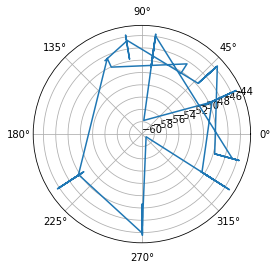

In [25]:
plt.polar(ele, 10*numpy.log10(ener))

In [73]:
angular = {"elevacion": ele, "energia": ener}
df = pd.DataFrame(data=angular)
df = df.groupby("elevacion")

In [74]:
dfm = df.mean()
dfm.head()

,energia
elevacion,
1.0,0.000019
2.0,0.000019
10.0,0.000022
11.0,0.000024
12.0,0.000023


In [122]:
elevacion = dfm.index.tolist()
elevacion = numpy.asarray(elevacion)
elevacion = elevacion*numpy.pi/180
energia = dfm["energia"].tolist()
energia = numpy.asarray(energia)
energia = 10*numpy.log10(energia)

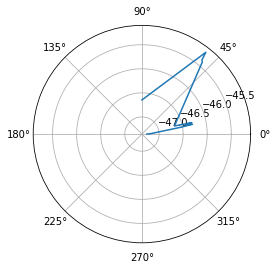

In [123]:
plt.polar(elevacion, energia)